In [76]:
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

In [77]:
import numpy as np
import sys
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages


In [78]:
sys.path.insert(0, "../python")
import BayesianOptimizationCustom as bo

In [79]:
optimizer_custum = bo.BayesianOptimizationCustom('../config/params_type.json', 
                                                 '../config/params_init_probe.json', 
                                                 None,
                                                 'output',
                                                 'output', 
                                                 10, 
                                                 '../config/params_type.json',
                                                 1)
params_range = optimizer_custum.ParamsRange()
params_range

{'num_den_layers_pre': (0, 5),
 'num_units_den_layers_pre': (1, 60),
 'num_den_layers_post': (0, 20),
 'num_units_den_layers_post': (1, 60),
 'num_rnn_layers': (1, 10),
 'num_units_rnn_layer': (1, 200),
 'learning_rate_exp': (-4, -2)}

In [103]:
optimizer = BayesianOptimization(
    f=None,
    pbounds=params_range,
    random_state=1, verbose=1
)
# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["06_12_2019_v20_opt.json"])

In [104]:
optimizer._gp.fit(optimizer._space.params, optimizer._space.target)

GaussianProcessRegressor(alpha=1e-06, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=25, normalize_y=True,
                         optimizer='fmin_l_bfgs_b',
                         random_state=RandomState(MT19937) at 0x7F51DD868360)

In [105]:
optimizer._space.params.shape

(56, 7)

In [106]:
optimizer._space.params.shape

(56, 7)

In [107]:
optimizer._space.keys

['learning_rate_exp',
 'num_den_layers_post',
 'num_den_layers_pre',
 'num_rnn_layers',
 'num_units_den_layers_post',
 'num_units_den_layers_pre',
 'num_units_rnn_layer']

In [121]:
# params = {'activation_dense_post' : 0, 'activation_dense_pre': 1, 'dropout_rate_den_layers_post' : 2,
#           'dropout_rate_den_layers_pre' : 3, 'dropout_rate_rnn': 4, 'learning_rate_exp': 5, 'num_den_layers_post': 6, 
#           'num_den_layers_pre': 7, 'num_rnn_layers': 8, 'num_units_den_layers_post': 9, 
#           'num_units_den_layers_pre': 10, 'num_units_rnn_layer': 11, 'optimizers': 12, 
#           'rnn_type': 13}

params = {'learning_rate_exp' : 0,
          'num_den_layers_post' : 1,
          'num_den_layers_pre': 2,
          'num_rnn_layers': 3,
          'num_units_den_layers_post': 4,
          'num_units_den_layers_pre': 5,
          'num_units_rnn_layer' : 6
         } 

In [109]:
params_pos = {}
for pos in range(len(optimizer._space.target)):
    params_pos[optimizer._space.target[pos]] = pos

In [110]:
order_targets = optimizer._space.target
order_targets = -np.sort(-order_targets)
best_10_order_targets = order_targets[:10]
print(best_10_order_targets)

[0.95178926 0.9517079  0.95042223 0.9493503  0.94929928 0.94924182
 0.94920516 0.9491477  0.94913179 0.94891483]


In [111]:
optimizer._space.target.argmax()

25

In [112]:
best_params = []
for point in best_10_order_targets:
    print(params_pos[point])
    best_params.append(optimizer._space.params[params_pos[point]])
#     max_point

25
2
38
0
41
14
51
12
19
26


In [113]:
# optimizer._space.params[1]

In [114]:
params_score = {}
params = []
for n in range(10):
    params_score[n] = best_params[n]

In [115]:
params_score

{0: array([-3., 13.,  0.,  5., 15.,  1., 74.]),
 1: array([-3., 10.,  0.,  5., 15., 15., 74.]),
 2: array([-3., 16.,  0.,  5., 15.,  1., 74.]),
 3: array([-3.,  0.,  0.,  5., 15., 15., 74.]),
 4: array([-3., 13.,  0.,  5., 15.,  1., 82.]),
 5: array([ -3.47403701,  19.87821588,   0.94085207,   3.31418635,
          1.38870681,  38.16171059, 191.6758524 ]),
 6: array([ -4.        ,  20.        ,   0.        ,  10.        ,
         60.        ,  29.76920191, 158.66107444]),
 7: array([-3.72962319, 18.93472522,  3.7943582 ,  7.88365782,  1.62497799,
        59.07140529, 88.24788695]),
 8: array([-3.68053713, 19.21262523,  0.51160202,  8.8177722 , 57.98865748,
        42.63674854, 18.92745967]),
 9: array([-3., 10.,  0.,  5., 18.,  1., 74.])}

In [116]:
# with open('10_best_params', 'w') as f:
#         f.write(json.dumps(best_params, indent=4))

In [117]:
max_point = optimizer._space.params[optimizer._space.target.argmax()]
max_point

array([-3., 13.,  0.,  5., 15.,  1., 74.])

In [118]:
best_params[n].shape[0]

7

In [119]:
def CreatePlots(max_point, var, pdf, n_bin, plot_title):
    var_points = np.linspace(params_range[var][0], params_range[var][1], 1000)#np.array([0, 1, 2, 3, 4, 5])
    x = np.zeros((var_points.shape[0], max_point.shape[0]))
    for n in range(x.shape[0]):
        x[n, :] = max_point[:]
        x[n, params[var]] = var_points[n]
#     print(x[:,0])
    mu, sigma = optimizer._gp.predict(x, return_std=True)
    max_idx = np.argmax(mu)
    print('{} max: mu={}, val={}'.format(var, mu[max_idx], x[max_idx, params[var]]))
#     print('mu:', mu)
#     print('sigma:', sigma)
#     print('2 * sigma:', 2 * sigma)
    fig = plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.plot(var_points, mu, '--', color='k', label='Prediction')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 2 * sigma, (mu + 2 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval', color='yellow')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 1 * sigma, (mu + 1 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='68% confidence interval', color='green')
    ax.set_ylabel('Purity')
    ax.set_xlabel(plot_title)
    plt.title(plot_title)
    ax.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    plt.draw()
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


num_den_layers_pre max: mu=0.9503042146745558, val=0.0


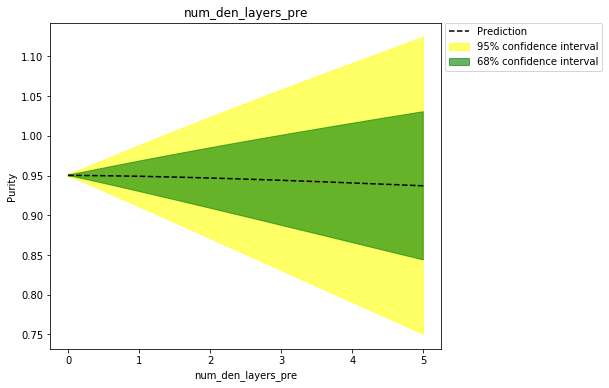

num_units_den_layers_pre max: mu=0.9568488034809336, val=35.785785785785784


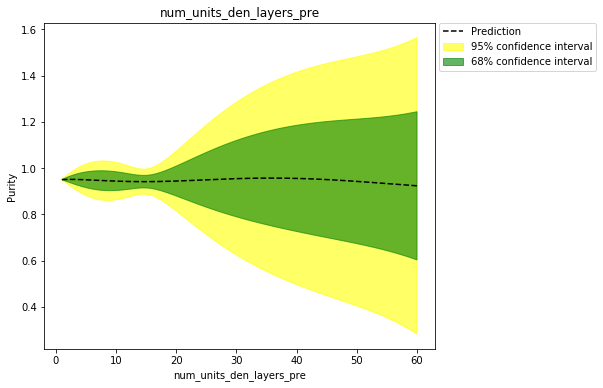

num_den_layers_post max: mu=0.9534023753885451, val=14.354354354354355


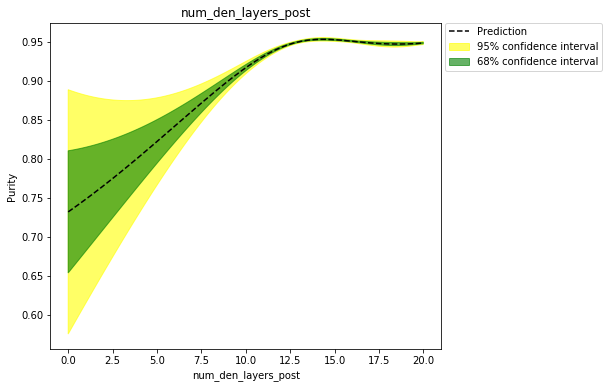

num_units_den_layers_post max: mu=0.9509271499748267, val=15.882882882882884


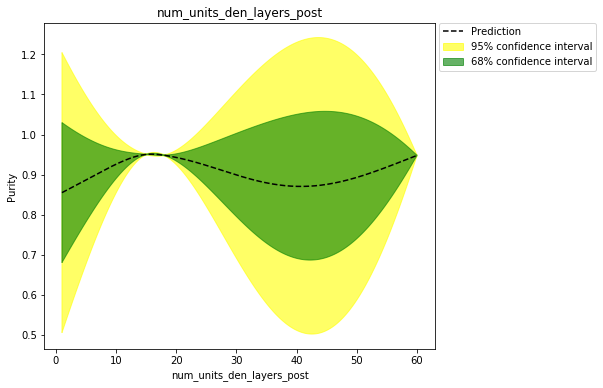

num_rnn_layers max: mu=0.9818010416772397, val=10.0


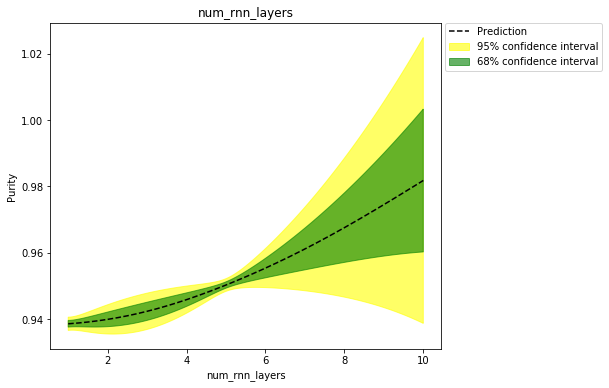

num_units_rnn_layer max: mu=0.9877617094025156, val=46.61661661661662


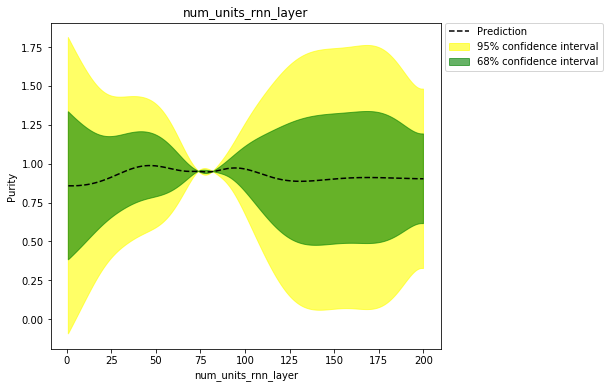

learning_rate_exp max: mu=0.9908966880452356, val=-4.0


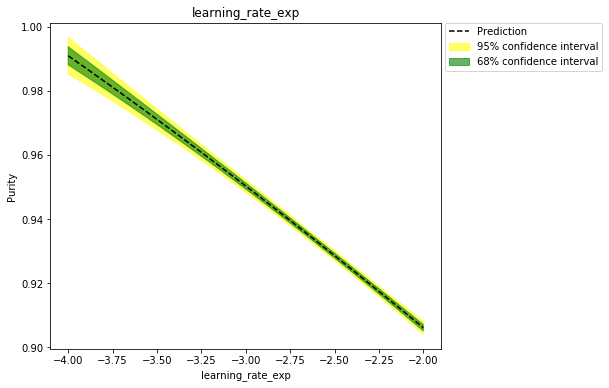

In [122]:
for n in range(1):
    with PdfPages('opt_plots_param_number_07_12_{}.pdf'.format(n)) as pdf:
        for key,values in params_range.items():
            CreatePlots(best_params[n], key, pdf, 'n_bin', key)
        


In [ ]:
for key,values in params_range.items():
    print(key)

In [ ]:
best_params[0]